In [240]:
### Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import resample

In [227]:
### Import data
data = pd.read_csv("uncorr20_data.csv")
# data = pd.read_csv("uncorr20_poly_data.csv")

submission_data = pd.read_csv("uncorr20_sub_data.csv")
# submission_data = pd.read_csv("uncorr20_poly_sub_data.csv")

# separate into X and Y
y = data.pop("Attrition")

# store column names
columns = data.columns

# set aside test data
train_X, test_X, train_Y, test_Y = train_test_split(data, y, 
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle=True)

# turn into np array
train_X, train_Y = np.array(train_X), np.array(train_Y)
test_X, test_Y = np.array(test_X), np.array(test_Y)
submission_data = np.array(submission_data)

In [228]:
print(submission_data.shape)
print(data.shape)

(336, 21)
(1340, 21)


In [229]:
def get_f1(model, X, y):
    preds = model.predict(X)
    f1 = f1_score(y, preds)
    return f1

In [230]:
# Baseline
adaboost = AdaBoostClassifier()

start = time.time()
adaboost.fit(train_X, train_Y)
stop = time.time()
print("Time to train: ", str(stop-start))

print(adaboost.get_params())

train_f1 = get_f1(adaboost, train_X, train_Y)
print("Train f1: ", train_f1)

test_f1 = get_f1(adaboost, test_X, test_Y)
print("Test f1: ", test_f1)

Time to train:  0.04631495475769043
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}
Train f1:  0.7136563876651982
Test f1:  0.6545454545454547


In [231]:
# Upsample
X = pd.concat([pd.DataFrame(train_X), pd.DataFrame(train_Y)], axis=1)
new_cols = np.append(np.array(columns), ["Attrition"])
X.columns = new_cols

not_attr = X[X.Attrition==0]
attr = X[X.Attrition==1]

attr_upsampled = resample(attr,
                          replace=True, # sample with replacement
                          n_samples=int(np.round(len(not_attr)/1.75)), # number of new samples
                          random_state=0) 

upsampled = pd.concat([not_attr, attr_upsampled])

train_Y_up = np.array(upsampled.pop("Attrition"))
train_X_up = np.array(upsampled)

In [232]:
# Up Baseline
adaboost = AdaBoostClassifier(n_estimators=30,
                              learning_rate=1)
adaboost.fit(train_X_up, train_Y_up)

train_f1 = get_f1(adaboost, train_X_up, train_Y_up)
print("Train f1: ", train_f1)

test_f1 = get_f1(adaboost, test_X, test_Y)
print("Test f1: ", test_f1)

Train f1:  0.865616311399444
Test f1:  0.5866666666666667


In [233]:
# Use upsampled data
# train_X, train_Y = train_X_up, train_Y_up

In [234]:
# Hyperparameter Tuning

# Define the parameter grid
param_grid = {
    "n_estimators": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "learning_rate": [2, 1.5, 1.25, 1, 0.75, 0.5, 0.25, 0.1, 
                      0.05, 0.01, 0.005, 0.001],
    "base_estimator": [DecisionTreeClassifier(max_depth=1), 
                       DecisionTreeClassifier(max_depth=2),
                       DecisionTreeClassifier(max_depth=3),
                       DecisionTreeClassifier(max_depth=4)],
}

train_scores, test_scores = {}, {}      # k: paramter being tuned; v: scores

for k, v in param_grid.items():
    print(k)
    
    train, test = [], []
    for v_i in v:
        NUM_SPLITS = 3
        cv_train = np.empty(NUM_SPLITS)
        cv_test = np.empty(NUM_SPLITS)
        cv = StratifiedKFold(n_splits=NUM_SPLITS)
        
        for idx, (train_idx, test_idx) in enumerate(cv.split(train_X, train_Y)):
            X_train, X_test = train_X[train_idx], train_X[test_idx]
            y_train, y_test = train_Y[train_idx], train_Y[test_idx] 
        
            adaboost = AdaBoostClassifier(**{k:v_i})
            adaboost.fit(X_train, y_train)
            
            train_f1 = get_f1(adaboost, X_test, y_test)
            test_f1 = get_f1(adaboost, test_X, test_Y)
            
            cv_train[idx] = train_f1
            cv_test[idx] = test_f1
            
        train.append(np.mean(cv_train))
        test.append(np.mean(cv_test))
    
    train_scores[k] = train
    test_scores[k] = test

n_estimators
learning_rate
base_estimator


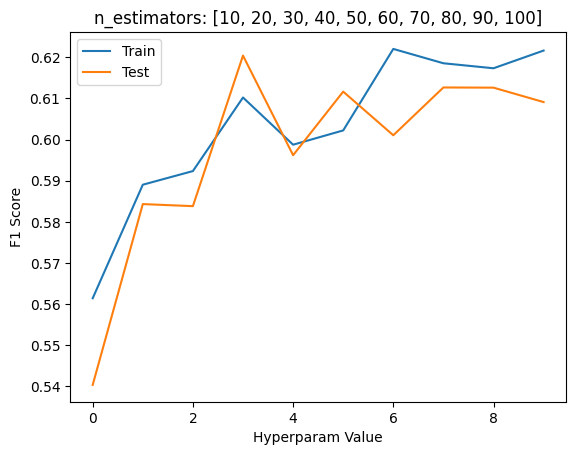

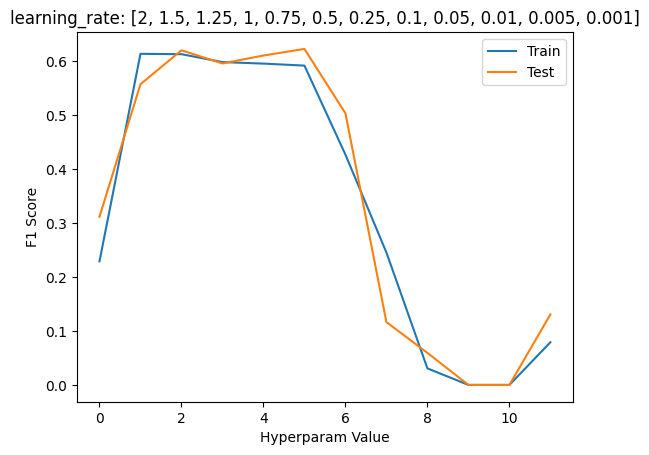

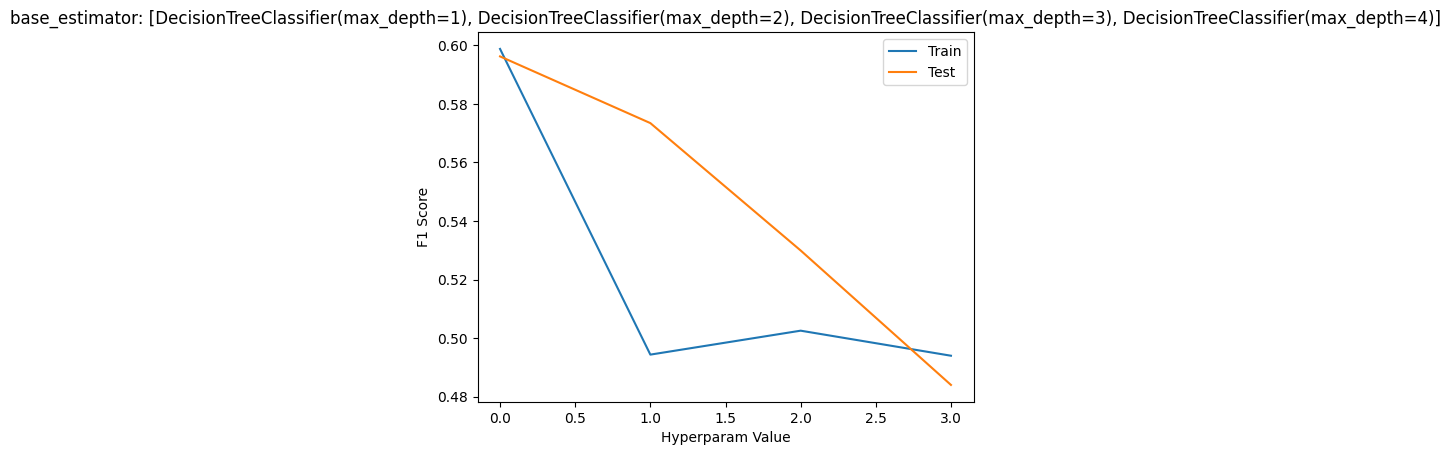

In [235]:
for k in train_scores.keys():
    plt.figure()
    plt.plot(list(range(len(train_scores[k]))), train_scores[k])
    plt.plot(list(range(len(train_scores[k]))), test_scores[k])
    plt.title(k + ": " + str(param_grid[k]))
    plt.xlabel("Hyperparam Value")
    plt.ylabel("F1 Score")
    plt.legend(["Train", "Test"])
    plt.show()

In [236]:
# Get best hyperparameters
best_params = {}
for k,v in train_scores.items():
    best_params[k] = param_grid[k][v.index(max(v))]
print(best_params)
    

{'n_estimators': 70, 'learning_rate': 1.5, 'base_estimator': DecisionTreeClassifier(max_depth=1)}


In [237]:
# Train model with best hyperparameters
ada_tuned = AdaBoostClassifier(**best_params)
ada_tuned.fit(train_X, train_Y)

train_f1 = get_f1(ada_tuned, train_X, train_Y)
print("Train f1: ", train_f1)

test_f1 = get_f1(ada_tuned, test_X, test_Y)
print("Test f1: ", test_f1)

Train f1:  0.7672413793103449
Test f1:  0.5964912280701754


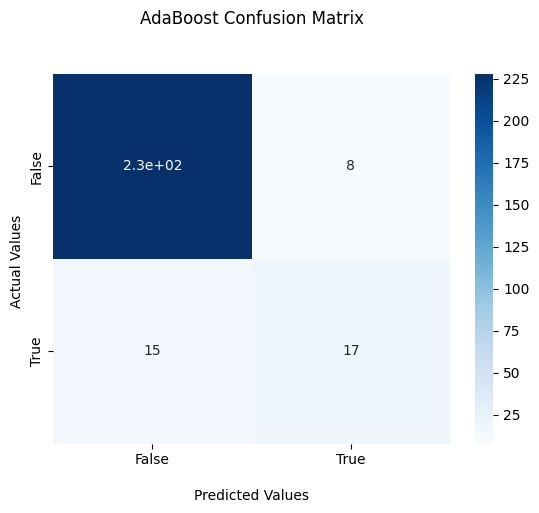

In [242]:
# Make a confusion matrix
c_matrix = confusion_matrix(test_Y, ada_tuned.predict(test_X))
ax = sns.heatmap(c_matrix, annot=True, cmap='Blues')
ax.set_title('AdaBoost Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [238]:
sub_preds = ada_tuned.predict(submission_data)

print( sum(sub_preds) / len(sub_preds))
print( sum(train_Y) / len(train_Y))
print( sum(test_Y) / len(test_Y))

0.08630952380952381
0.11847014925373134
0.11940298507462686


In [239]:
# get predictions for submission
sub_preds = ada_tuned.predict(submission_data)
ids = list(range(0, len(sub_preds)))

output_data = pd.DataFrame({"Id": ids, "Predicted": sub_preds})
output_data = output_data.set_index("Id")

output_data.to_csv("ada_submission.csv")